## 使用python+numpy实现房价预测

iter:0,loss:962.4130921751794
iter:20,loss:128.34956618316167
iter:40,loss:104.9265908994852
iter:60,loss:91.05496706808992
iter:80,loss:80.14480540358527
iter:100,loss:71.48244084194357
iter:120,loss:64.57698102820974
iter:140,loss:59.05840981661155
iter:160,loss:54.635037375701536
iter:180,loss:51.072126322096615
iter:200,loss:48.180399885115534
iter:220,loss:45.80871249651883
iter:240,loss:43.83822622995728
iter:260,loss:42.17710007557318
iter:280,loss:40.75550286256443
iter:300,loss:39.52105812934185
iter:320,loss:38.43486685561091
iter:340,loss:37.46818965373929
iter:360,loss:36.59978979032736
iter:380,loss:35.81387847093646
iter:400,loss:35.098571907790046
iter:420,loss:34.44476085105923
iter:440,loss:33.845299169795524
iter:460,loss:33.29443133090572
iter:480,loss:32.78739412097827
iter:500,loss:32.320142726340706
iter:520,loss:31.88916395474163
iter:540,loss:31.49134955362471
iter:560,loss:31.123910385008177
iter:580,loss:30.784318011070916
iter:600,loss:30.47026443860598
iter:

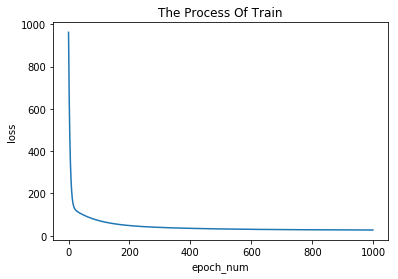

In [12]:
#导入需要用到的包
import numpy as np
import matplotlib.pyplot as plt

#数据导入以及处理
def deal_data():
    #读取文件数据，此时数据形状是(7084,)，即所有数据在一行中
    housingdata = np.fromfile('/home/aistudio/data/data64/housing.data',sep=' ')

    #修改数据格式，将每一条房屋数据放在一行中。
    housingdata = np.array(housingdata).reshape((-1,14))#此时数据形状为(506,14)

    #对数据的前13个属性进行归一化操作，有助于提高模型精准度，这里使用max-min归一化方式。公式为(x-min)/(max-min)
    for i in range(13):
        Max =  np.max(housingdata[:,i])
        Min = np.min(housingdata[:,i])
        housingdata[:,i]=(housingdata[:,i]-Min)/(Max-Min)

    #依据2-8原则，80%的数据作为训练数据，20%数据作为测试数据；此时训练数据是405条，测试数据是101条
    Splitdata = round(len(housingdata)*0.8)
    Train = housingdata[:Splitdata]#训练数据集
    Test = housingdata[Splitdata:]#测试数据集
    return Train,Test

#模型设计以及配置
#首先确定有13个权值参数w，并随机初始化
class Model_Config(object):
    def __init__(self,firstnetnum,secondnetnum):
        np.random.seed(1)
        self.w0 = np.random.randn(firstnetnum*secondnetnum,1).reshape(firstnetnum,secondnetnum)
        self.w1 = np.random.randn(secondnetnum,1)
        self.b0 = np.random.randn(firstnetnum,1).reshape(1,firstnetnum)
        self.b1 = np.random.randn(1,1)
     #计算预测值
    def forward(self,x):
        hidden1 = np.dot(x,self.w0)+self.b0
        y = np.dot(hidden1,self.w1)+self.b1
        return hidden1,y
    #设置损失函数,这里使用差平方损失函数计算方式
    def loss(self,z,y):
        error = z-y
        cost = error*error
        avg_cost = np.mean(cost)
        return avg_cost
    #计算梯度
    def back(self,x,y):
        hidden1,z = self.forward(x)
        #hidden层的梯度
        gradient_w1 = (z-y)*hidden1
        gradient_w1 = np.mean(gradient_w1,axis=0)#这里注意，axis=0必须写上，否则默认将这个数组变成一维的求平均
        gradient_w1 = gradient_w1[:,np.newaxis]#
        gradient_b1 = (z-y)
        gradient_b1 = np.mean(gradient_b1)
        gradient_w0 = np.zeros(shape=(13,13))
        for i in range(len(x)):
            data = x[i,:]
            data = data[:,np.newaxis]
            # print("data.shape",data.shape)
            w1 = self.w1.reshape(1,13)
            # print("self.w1.shape",w1.shape)
            gradient_w01 = (z-y)[i]*np.dot(data,w1)
            # print("gradient_w01.shape:",gradient_w01.shape)
            gradient_w0+=gradient_w01
        gradient_w0 = gradient_w0/len(x)
        w2 = self.w1.reshape(1,13)
        gradient_b0 =np.mean((z-y)*w2,axis=0)

        return gradient_w1,gradient_b1,gradient_w0,gradient_b0
        #输入层的梯度
        #(z-y)x*self.w1
        # gradient_w0 = np.zeros(shape=(13,13))
        # gradient_w01 = gradient_w1.reshape(1,13)
        # for i in range(13):
        #     data = x[:,i]
        #     data = data[:,np.newaxis]
        #     gradient = data*gradient_w01
        #     gradient = np.mean(gradient,axis=0)
        #     gradient_w0[i,:] = gradient
        # gradient_b0 = gradient_b1*self.b0
        # return gradient_w1,gradient_b1,gradient_w0,gradient_b0

    #使用梯度更新权值参数w
    def update(self,gradient_w1,gradient_b1,gradient_w0,gradient_b0,learning_rate):
        self.w1 = self.w1-learning_rate*gradient_w1
        self.b1 = self.b1-learning_rate*gradient_b1
        self.w0 = self.w0-learning_rate*gradient_w0
        self.b0 = self.b0-learning_rate*gradient_b0

    #开始训练
    def train(self,epoch_num,x,y,learning_rate):
        #循环迭代
        losses=[]
        for i in range(epoch_num):
            _,z = self.forward(x)
            avg_loss = self.loss(z,y)
            gradient_w1,gradient_b1,gradient_w0,gradient_b0 = self.back(x,y)
            self.update(gradient_w1,gradient_b1,gradient_w0,gradient_b0,learning_rate)
            losses.append(avg_loss)
            #每进行20此迭代，显示一下当前的损失值
            if(i%20==0):
                print("iter:{},loss:{}".format(i,avg_loss))

        return losses
def showpeocess(loss,epoch_num):
    plt.title("The Process Of Train")
    plt.plot([i for i in range(epoch_num)],loss)
    plt.xlabel("epoch_num")
    plt.ylabel("loss")
    plt.show()
if __name__ == '__main__':
    Train,Test = deal_data()
    np.random.shuffle(Train)
    #只获取前13个属性的数据
    x = Train[:,:-1]
    y = Train[:,-1:]
    epoch_num = 1000#设置迭代次数
    Model = Model_Config(13,13)
    losses = Model.train(epoch_num=epoch_num,x=x,y=y,learning_rate=0.001)
    showpeocess(loss=losses,epoch_num=epoch_num)


## 使用飞桨框架进行房价预测

In [18]:
## 导库
import paddle.fluid as fluid
import paddle
import numpy as np
import os
import matplotlib.pyplot as plt

In [19]:
BUF_SIZE=500
BATCH_SIZE=20

In [20]:
#用于训练的数据提供器，每次从缓存中随机读取批次大小的数据
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.train(), 
                          buf_size=BUF_SIZE),                    
    batch_size=BATCH_SIZE)   
#用于测试的数据提供器，每次从缓存中随机读取批次大小的数据
test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.test(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)  

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
API "paddle.dataset.uci_housing.train" is deprecated since 2.0.0, and will be removed in future versions. Please use "paddle.text.datasets.UCIHousing" instead.
reason: Please use new dataset API which supports paddle.io.DataLoader 
  This is separate from the ipykernel package so we can avoid doing imports until
Cache file /home/aistudio/.cache/paddle/dataset/uci_housing/housing.data not found, downloading http://paddlemodels.bj.bcebos.com/uci_housing/housing.data 
Begin to download
............
Download finished
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
API "paddle.dataset.uci_housing.test" is deprecated since 2.0.0, and will be removed in future versions. Please use "paddle.text.datasets.UCIHousing" instead.
reason: Please use new dataset API which supports paddle.io.DataLoader 
  


In [21]:
#用于打印，查看uci_housing数据
train_data=paddle.dataset.uci_housing.train();
sampledata=next(train_data())
print(sampledata)

(array([-0.0405441 ,  0.06636364, -0.32356227, -0.06916996, -0.03435197,
        0.05563625, -0.03475696,  0.02682186, -0.37171335, -0.21419304,
       -0.33569506,  0.10143217, -0.21172912]), array([24.]))


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
API "paddle.dataset.uci_housing.train" is deprecated since 2.0.0, and will be removed in future versions. Please use "paddle.text.datasets.UCIHousing" instead.
reason: Please use new dataset API which supports paddle.io.DataLoader 
  


In [23]:
paddle.enable_static()
#定义张量变量x，表示13维的特征值
x = fluid.layers.data(name='x', shape=[13], dtype='float32')
#定义张量y,表示目标值
y = fluid.layers.data(name='y', shape=[1], dtype='float32')
#定义一个简单的线性网络,连接输入和输出的全连接层
#input:输入tensor;
#size:该层输出单元的数目
#act:激活函数
y_predict=fluid.layers.fc(input=x,size=1,act=None)

In [24]:
cost = fluid.layers.square_error_cost(input=y_predict, label=y) #求一个batch的损失值
avg_cost = fluid.layers.mean(cost)                              #对损失值求平均值

In [25]:
optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)
opts = optimizer.minimize(avg_cost)

In [26]:
test_program = fluid.default_main_program().clone(for_test=True)

In [27]:
use_cuda = False                         #use_cuda为False,表示运算场所为CPU;use_cuda为True,表示运算场所为GPU           
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)              #创建一个Executor实例exe
exe.run(fluid.default_startup_program()) #Executor的run()方法执行startup_program(),进行参数初始化

[]

In [28]:
# 定义输入数据维度
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])#feed_list:向模型输入的变量表或变量表名

In [29]:
iter=0;
iters=[]
train_costs=[]

def draw_train_process(iters,train_costs):
    title="training cost"
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs,color='red',label='training cost') 
    plt.grid()
    plt.show()

Pass:0, Cost:592.36249
Test:0, Cost:145.44810
Pass:1, Cost:589.56329
Test:1, Cost:178.84985
Pass:2, Cost:570.84943
Test:2, Cost:168.94835
Pass:3, Cost:438.91205
Test:3, Cost:141.38052
Pass:4, Cost:505.20087
Test:4, Cost:88.85927
Pass:5, Cost:457.30194
Test:5, Cost:176.04980
Pass:6, Cost:258.72754
Test:6, Cost:151.16528
Pass:7, Cost:448.93439
Test:7, Cost:62.47404
Pass:8, Cost:333.64215
Test:8, Cost:16.51198
Pass:9, Cost:331.10992
Test:9, Cost:14.78093
Pass:10, Cost:444.56696
Test:10, Cost:74.18665
Pass:11, Cost:422.36493
Test:11, Cost:110.44833
Pass:12, Cost:285.92731
Test:12, Cost:21.81844
Pass:13, Cost:258.82297
Test:13, Cost:63.62513
Pass:14, Cost:387.42661
Test:14, Cost:60.32746
Pass:15, Cost:121.29138
Test:15, Cost:30.62586
Pass:16, Cost:177.93475
Test:16, Cost:76.13977
Pass:17, Cost:238.23148
Test:17, Cost:8.09512
Pass:18, Cost:245.80237
Test:18, Cost:79.30521
Pass:19, Cost:98.33235
Test:19, Cost:47.22866
Pass:20, Cost:48.12200
Test:20, Cost:50.03571
Pass:21, Cost:123.04604
Test:

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


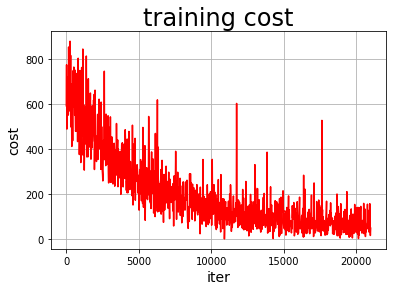

In [30]:
EPOCH_NUM=50
model_save_dir = "/home/aistudio/work/fit_a_line.inference.model"

for pass_id in range(EPOCH_NUM):                                  #训练EPOCH_NUM轮
    # 开始训练并输出最后一个batch的损失值
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):              #遍历train_reader迭代器
        train_cost = exe.run(program=fluid.default_main_program(),#运行主程序
                             feed=feeder.feed(data),              #喂入一个batch的训练数据，根据feed_list和data提供的信息，将输入数据转成一种特殊的数据结构
                             fetch_list=[avg_cost])    
        if batch_id % 40 == 0:
            print("Pass:%d, Cost:%0.5f" % (pass_id, train_cost[0][0]))    #打印最后一个batch的损失值
        iter=iter+BATCH_SIZE
        iters.append(iter)
        train_costs.append(train_cost[0][0])
       
   
    # 开始测试并输出最后一个batch的损失值
    test_cost = 0
    for batch_id, data in enumerate(test_reader()):               #遍历test_reader迭代器
        test_cost= exe.run(program=test_program, #运行测试cheng
                            feed=feeder.feed(data),               #喂入一个batch的测试数据
                            fetch_list=[avg_cost])                #fetch均方误差
    print('Test:%d, Cost:%0.5f' % (pass_id, test_cost[0][0]))     #打印最后一个batch的损失值
    
    #保存模型
    # 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
#保存训练参数到指定路径中，构建一个专门用预测的program
fluid.io.save_inference_model(model_save_dir,   #保存推理model的路径
                                  ['x'],            #推理（inference）需要 feed 的数据
                                  [y_predict],      #保存推理（inference）结果的 Variables
                                  exe)              #exe 保存 inference model
draw_train_process(iters,train_costs)

In [31]:
infer_exe = fluid.Executor(place)    #创建推测用的executor
inference_scope = fluid.core.Scope() #Scope指定作用域

In [32]:
infer_results=[]
groud_truths=[]

#绘制真实值和预测值对比图
def draw_infer_result(groud_truths,infer_results):
    title='Boston'
    plt.title(title, fontsize=24)
    x = np.arange(1,20) 
    y = x
    plt.plot(x, y)
    plt.xlabel('ground truth', fontsize=14)
    plt.ylabel('infer result', fontsize=14)
    plt.scatter(groud_truths, infer_results,color='green',label='training cost') 
    plt.grid()
    plt.show()

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
API "paddle.dataset.uci_housing.test" is deprecated since 2.0.0, and will be removed in future versions. Please use "paddle.text.datasets.UCIHousing" instead.
reason: Please use new dataset API which supports paddle.io.DataLoader 
  if __name__ == '__main__':
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


infer results: (House Price)
0: 14.19
1: 14.45
2: 13.88
3: 15.21
4: 14.31
5: 14.86
6: 14.57
7: 14.25
8: 12.43
9: 14.23
10: 12.10
11: 13.36
12: 13.89
13: 13.55
14: 13.69
15: 14.37
16: 15.16
17: 15.03
18: 15.32
19: 14.02
20: 14.60
21: 13.51
22: 15.06
23: 14.67
24: 14.43
25: 13.89
26: 14.84
27: 14.73
28: 15.54
29: 14.68
30: 14.53
31: 14.07
32: 14.16
33: 13.23
34: 12.97
35: 14.54
36: 14.67
37: 15.02
38: 15.14
39: 15.05
40: 14.05
41: 13.74
42: 14.94
43: 15.21
44: 15.12
45: 14.86
46: 14.34
47: 15.23
48: 15.32
49: 15.65
50: 14.24
51: 14.46
52: 14.04
53: 14.29
54: 15.23
55: 15.60
56: 15.21
57: 15.64
58: 15.78
59: 16.00
60: 16.26
61: 16.14
62: 14.41
63: 15.03
64: 15.77
65: 16.27
66: 15.88
67: 16.16
68: 16.28
69: 16.67
70: 15.07
71: 14.74
72: 15.54
73: 14.38
74: 15.36
75: 15.89
76: 16.80
77: 17.03
78: 17.19
79: 17.08
80: 16.67
81: 16.94
82: 16.03
83: 16.65
84: 16.64
85: 15.94
86: 15.31
87: 16.74
88: 17.39
89: 20.60
90: 20.78
91: 20.63
92: 19.48
93: 20.21
94: 20.47
95: 19.97
96: 20.11
97: 21.40
9

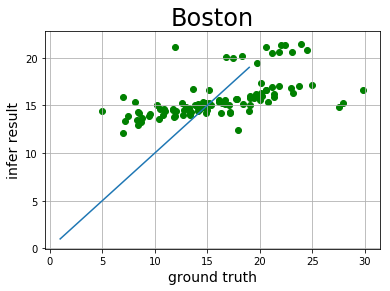

In [33]:
with fluid.scope_guard(inference_scope):#修改全局/默认作用域（scope）, 运行时中的所有变量都将分配给新的scope。
    #从指定目录中加载 推理model(inference model)
    [inference_program,                             #推理的program
     feed_target_names,                             #需要在推理program中提供数据的变量名称
     fetch_targets] = fluid.io.load_inference_model(#fetch_targets: 推断结果
                                    model_save_dir, #model_save_dir:模型训练路径 
                                    infer_exe)      #infer_exe: 预测用executor
    #获取预测数据
    infer_reader = paddle.batch(paddle.dataset.uci_housing.test(),  #获取uci_housing的测试数据
                          batch_size=200)                           #从测试数据中读取一个大小为200的batch数据
    #从test_reader中分割x
    test_data = next(infer_reader())
    test_x = np.array([data[0] for data in test_data]).astype("float32")
    test_y= np.array([data[1] for data in test_data]).astype("float32")
    results = infer_exe.run(inference_program,                              #预测模型
                            feed={feed_target_names[0]: np.array(test_x)},  #喂入要预测的x值
                            fetch_list=fetch_targets)                       #得到推测结果 
                            
    print("infer results: (House Price)")
    for idx, val in enumerate(results[0]):
        print("%d: %.2f" % (idx, val))
        infer_results.append(val)
    print("ground truth:")
    for idx, val in enumerate(test_y):
        print("%d: %.2f" % (idx, val))
        groud_truths.append(val)
    draw_infer_result(groud_truths,infer_results)